<p align="center">
  <img src="assets/etab_logo.png" width="320">
</p>

# Demo 2: Running an ETAB Benchmark Experiment Out-of-the-Box

This notebook provides a brief tutorial for running a composing models and running benchmark experiments in ETAB. We start by importing the relevant modules as follows:

In [1]:
import os

current_dir = os.path.split(os.getcwd())[0]

os.chdir(current_dir)

from etab.baselines.models import *
from etab.datasets import *
from etab.utils.visualization import *
from etab.utils.data_tools import *

import warnings
warnings.filterwarnings("ignore")


cuda_device      = 0
device           = torch.device("cuda:%d" % cuda_device if torch.cuda.is_available() else "cpu")

GPU(s) available:  NVIDIA A100-SXM4-40GB


Throughout this notebook, the benchmark task we will conduct is "a0-A4-E" and the model will be a ResNet-50 backbone with a SegFormer head.

## Loading an ETAB dataset and creating train/test splits

In Demo 1, we have shown how to create an ETAB dataset class and load echocardiogram data with the desired parameters. Here, we start by repeating the same steps we conducted in Demo1 to load data for task a0-A4-E in the following cells.

In [2]:
echonet     = ETAB_dataset(name="echonet",
                           target="LV_seg", 
                           view="A4",
                           video=False,
                           normalize=True,
                           frame_l=224,
                           frame_w=224,
                           clip_l=1)

In [3]:
echonet.load_data(n_clips=7000)

Next, we will split the dataset saved in echonet.data into training, validation and testing samples. To do so, we first need to specify the desired batch size in order to create the data loaders

In [4]:
batch_size = 32

To split the data, we use the *training_data_split* function and set the *return_loaders* flag to *True*. This retrieves iterables that can be used to load minibatches in model training and evaluation.

In [5]:
train_loader, valid_loader, test_loader = training_data_split(echonet.data, train_frac=0.6, val_frac=0.1, 
                                                              batch_size=batch_size, return_loaders=True)

Now let us create the model. This can be achieved by creating an instance of the *ETABmodel* class and setting the attributes to the desired values.

In [6]:
model      = ETABmodel(task="segmentation",
                       backbone='ResNet-50', 
                       head="SegFormer")

To train the model, we can invoke the *.fit* method in *ETABmodel* class after setting the training parameters as follows:

In [7]:
learning_rate = 0.001
n_epoch       = 100
ckpt_dir      = "a0-A4-E"  # This is the directoty in which the model callbacks are saved

In [ ]:
model.fit(train_loader=train_loader, 
          valid_loader=valid_loader, 
          task_code="EA40", 
          n_epoch=n_epoch,
          learning_rate=learning_rate,
          ckpt_dir=ckpt_dir,
          device=device)

Now let us inspect the trained model's outputs for a minibatch in test data. We can do this by invoking the *.predict* method in *ETABmodel* as follows:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


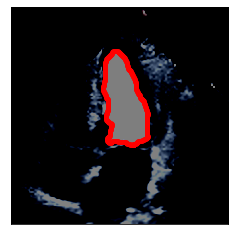

In [9]:
output_index          = 20
inputs, ground_truths = next(iter(test_loader))
preds                 = model.predict(inputs) 

plot_segment(inputs[output_index, :, :, :], 
             preds[output_index, :, :], 
             overlay=True, color="r")

To evaluate the trained model, we can use the *evaluate_model* function in *etab.utils.metrics* module. This function takes the model and test loader as inputs and returns the model performance assesed using the relevant metric. In this case, the metric is the Jaccard Index.

In [10]:
from etab.utils.metrics import *

evaluate_model(model, test_loader)

Test steps: 66 3.99s test_loss: 0.059588 test_acc: 97.813304 test_fscore_macro: 0.907333 test_jaccard_index: 0.840497


0.8404970169067383

Now consider the scenario where we would like to freeze the backbone representation and only tune the head. How would that impact the overall performance on task "a0-A4-E" compared to the full finetuning process above? To implement this baseline, we create yet a new instance of *ETABmodel* followed by the *freeze_backbone* method as follows:

In [11]:
model      = ETABmodel(task="segmentation",
                       backbone='ResNet-50', 
                       head="SegFormer")


model.freeze_backbone()

Next, we repeat the training procedure above by calling the *.fit* method again:

In [ ]:
ckpt_dir  = "a0-A4-E-frozen" 

model.fit(train_loader=train_loader, 
          valid_loader=valid_loader, 
          task_code="EA40", 
          n_epoch=n_epoch,
          learning_rate=learning_rate,
          ckpt_dir=ckpt_dir,
          device=device)

And finally, we evaluated the trained model:

In [13]:
evaluate_model(model, test_loader)

Test steps: 66 3.56s test_loss: 0.131811 test_acc: 96.155781 test_fscore_macro: 0.831458 test_jaccard_index: 0.739468


0.7394677400588989

As we can see, by limiting the representational capacity of the model, the achieved performance is inferior to the fully finetuned model.